# Analyzing player momentum at the time of ball snap to investigate hidden advantages in targetting open gaps present from presnap motion

# Project outline:

# The goal is to calculate momentum change advantage scores to plot completion rates against time to throw and distance of intended receiver 

### For only defensive players that play off of the line, determine player momentum (magnitude and direction) at the time the ball is snapped.
### For only pass plays, identify the position of the intended reciever to obtain the closest off-line defnesive player.
### Calculate the momentum of this closest defensive player when the ball arrives.
### Define a metric that is numeric that represents how damaging the defensive player's momentum at the snap is to the result of the play. 
    p*cos(theta)
### This dot product represents the portion of the momentum at snap that is aligned with the momentum at the time the pass arrives.




In [18]:
import sqlite3
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from general import *
pd.set_option('display.max_columns', None)

# To initiate the data base and close the database, use the following:
BDB25_db = sqlite3.connect("big_data_bowl_2025.db") 

BDB25_cursor = BDB25_db.cursor()

#BDB25_db.commit() # Commits changes to the database
#BDB25_db.close() # Closes the database

# Query the data using the SQL files

In [132]:
query_for_momentum = load_query('defensive_player_momentum_and_pass_position')
query_for_play_info = load_query('pass_play_info')
defensive_players_at_pass = load_query('defensive_players_at_pass')
defensive_player_momentum_at_pass = load_query('defensive_player_momentum_at_pass')



p_at_snap = make_a_query(BDB25_cursor, query_for_momentum)
p_at_target = make_a_query(BDB25_cursor, defensive_player_momentum_at_pass)
play_info = make_a_query(BDB25_cursor, query_for_play_info)

# Define the momentum dataframe by merging wrangled tables

In [134]:
A = p_at_target.merge(play_info, on=['gameId', 'playId'], how='right')
A['distance_to_intended_reciever'] = A.apply(lambda row: np.sqrt((row['x']-row['targetX'])**2+(row['y']-row['targetY'])**2), axis=1)


momentum_df = A.sort_values(
    ['gameId', 'playId', 'distance_to_intended_reciever']
).drop_duplicates([
    'gameId', 'playId'], 
                  keep='first'
                 ).rename(
    columns={'nflId_x':'nflId'}
).merge(
    p_at_snap[['gameId', 'playId', 'nflId', 'p_at_snap', 'dir']], 
    on=['gameId', 'playId', 'nflId'], 
    how='inner'
).rename(columns = {'dir_x':'dir_at_target', 'dir_y':'dir_at_snap'})

In [136]:
momentum_df['angle_diff'] = momentum_df.apply(
    lambda row: 
        np.abs(
            row['dir_at_snap']-row['dir_at_target']
        ), 
    axis=1)


momentum_df['momentum_change_advantage'] = momentum_df.apply(
    lambda row: np.cos(row['angle_diff']*np.pi/180)*row['p_at_snap'], 
    axis=1)



keep_cols = ['gameId', 'playId', 'nflId', 'playDirection','p_at_snap', 
              'dir_at_snap', 'dir_at_target', 'p_at_target', 
             'position', 'routeRan', 'hadPassReception', 'quarter',	
             'down',	'gameClock',	'HomeTeamUpBy',	'passResult',	
             'targetX',	'targetY',	'timeToThrow',	'homeTeamWinProbabilityAdded',	
             'pff_passCoverage',	'pff_manZone',	'distance_to_intended_reciever', 'momentum_change_advantage']

p_cols = ['gameId', 'playId', 'nflId',  
              'dir_at_snap', 'dir_at_target', 'angle_diff', 'p_at_snap', 'p_at_target', 
             'passResult',	'distance_to_intended_reciever', 'momentum_change_advantage']


In [138]:
momentum_df.passResult.value_counts()

passResult
C     5394
I     1265
IN     125
R        1
Name: count, dtype: int64

# Visualize momentum change advantage patterns

Text(0, 0.5, 'Momentum Change Advantage')

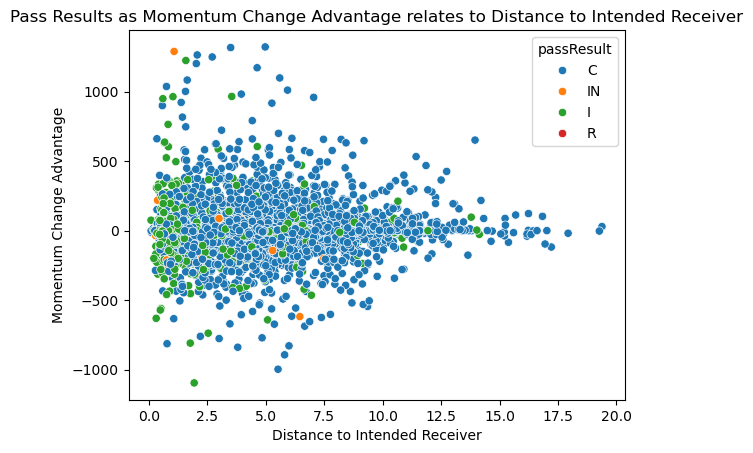

In [146]:
sns.scatterplot(data = momentum_df, x = 'distance_to_intended_reciever', y = 'momentum_change_advantage', hue = 'passResult')
plt.title('Pass Results as Momentum Change Advantage relates to Distance to Intended Receiver')
plt.xlabel('Distance to Intended Receiver')
plt.ylabel('Momentum Change Advantage')

Text(0, 0.5, 'Momentum Change Advantage')

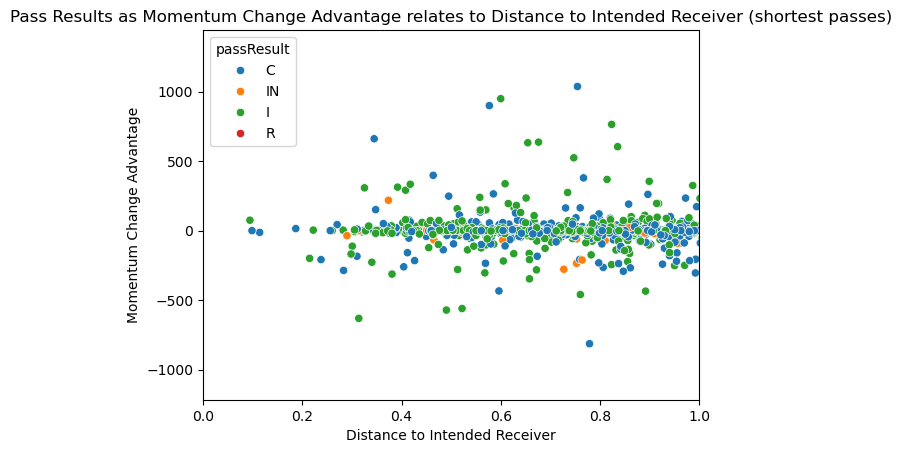

In [150]:
sns.scatterplot(data = B, x = 'distance_to_intended_reciever', y = 'momentum_change_advantage', hue = 'passResult')
plt.xlim(0, 1)
plt.title('Pass Results as Momentum Change Advantage relates to Distance to Intended Receiver (shortest passes)')
plt.xlabel('Distance to Intended Receiver')
plt.ylabel('Momentum Change Advantage')

Text(0, 0.5, 'Momentum Change Advantage')

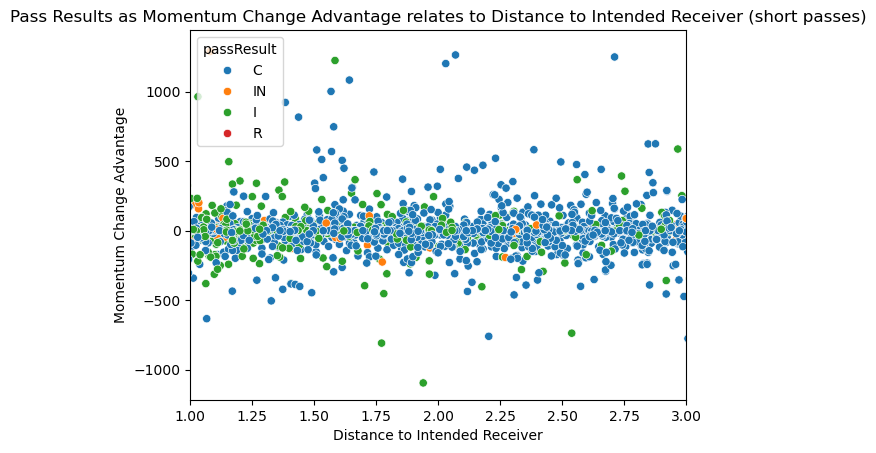

In [152]:
sns.scatterplot(data = B, x = 'distance_to_intended_reciever', y = 'momentum_change_advantage', hue = 'passResult')
plt.xlim(1, 3)
plt.title('Pass Results as Momentum Change Advantage relates to Distance to Intended Receiver (short passes)')
plt.xlabel('Distance to Intended Receiver')
plt.ylabel('Momentum Change Advantage')

Text(0, 0.5, 'Momentum Change Advantage')

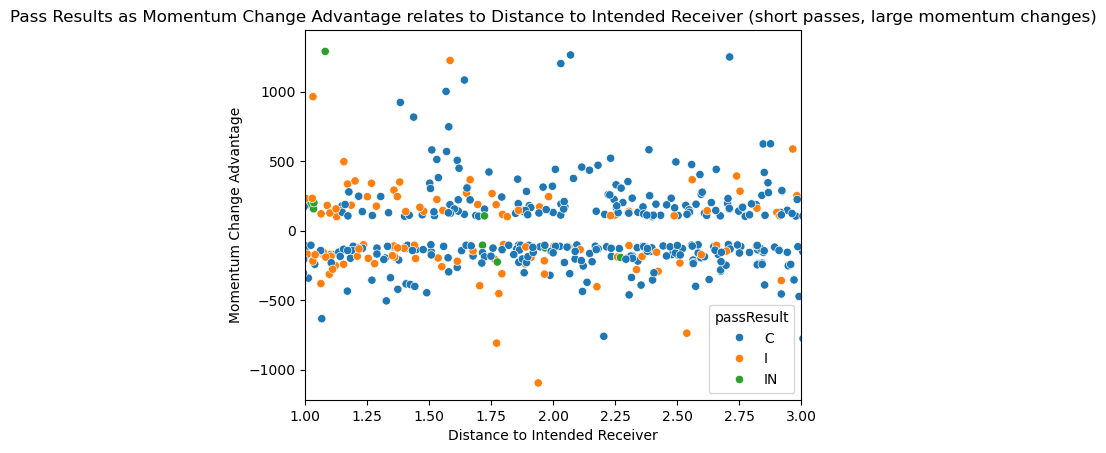

In [154]:
sns.scatterplot(data = B[abs(B['momentum_change_advantage'])>100], x = 'distance_to_intended_reciever', y = 'momentum_change_advantage', hue = 'passResult')
plt.xlim(1, 3)
plt.title('Pass Results as Momentum Change Advantage relates to Distance to Intended Receiver (short passes, large momentum changes)')
plt.xlabel('Distance to Intended Receiver')
plt.ylabel('Momentum Change Advantage')

Text(0, 0.5, 'Momentum Change Advantage')

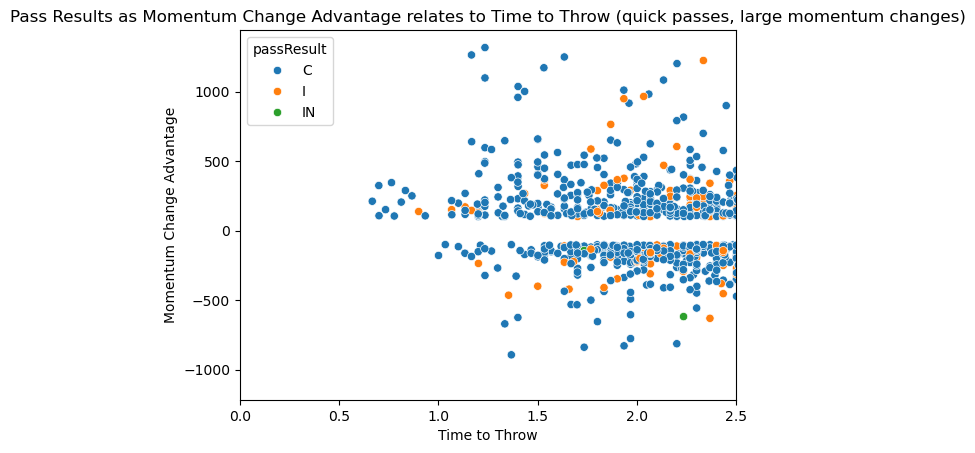

In [156]:
sns.scatterplot(data = B[abs(B['momentum_change_advantage'])>100], x = 'timeToThrow', y = 'momentum_change_advantage', hue = 'passResult')
plt.xlim(0, 2.5)

plt.title('Pass Results as Momentum Change Advantage relates to Time to Throw (quick passes, large momentum changes)')
plt.xlabel('Time to Throw')
plt.ylabel('Momentum Change Advantage')

# What is the completion percentage for quick throws with good and bad momentum change advantages (negative --> worse for the defender)

### To note: we see a better completion percentage when the defender's momentum was positive! This is the oppositite of what was expected, and shows that the signal from this feature is too small to overcome correlated effects like route ran, coverage type, and other contextual factors.

In [159]:
pd.DataFrame(B[
    (abs(B['momentum_change_advantage'])>100) & (B['momentum_change_advantage']<0) & (B['timeToThrow']<2) & (B['down'].isin([3, 4]))
]['passResult'].value_counts(normalize=True))

,proportion
passResult,
C,0.8
I,0.2


In [161]:
pd.DataFrame(B[
    (abs(B['momentum_change_advantage'])>100) & (B['momentum_change_advantage']>0) & (B['timeToThrow']<2) & (B['down'].isin([3, 4]))
]['passResult'].value_counts(normalize=True))

,proportion
passResult,
C,0.870968
I,0.129032


# What are the average momentum change advantages by the route of the WR?

In [166]:

B[['routeRan','momentum_change_advantage']].groupby('routeRan').agg(['mean', 'std', 'count'])

momentum_change_advantage                  
                              mean         std count
routeRan                                            
ANGLE                    -6.892174  101.267351   289
CORNER                   -9.592698  155.547255   175
CROSS                     6.385599  153.964034   810
FLAT                     17.868494  167.441656  1035
GO                       17.966220  119.417875   496
HITCH                   -18.905869  131.205891  1072
IN                      -30.917453  124.617824   425
OUT                      12.456401  141.678998   925
POST                    -19.218342  122.449572   306
SCREEN                   29.757374  139.572677   744
SLANT                   -16.753964  104.783115   470
WHEEL                    16.538350  241.065255    34

In [218]:
#BDB25_db.close()